In [146]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/Thumbs.db
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_113.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_12.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_114.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_117.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_112.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_111.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_11.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/In_110.bmp
/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid/Inclusion/

In [147]:
# Set the path to the root directory of your dataset
train_data_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
test_data_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
valid_data_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'

In [148]:
# Define the image size for resizing (VGG16 requires input size of 224x224)
image_size = (224, 224)

In [149]:
# Batch size for training
batch_size = 32

In [150]:
# Function to preprocess a single image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=image_size)  # Load image and resize
    img_array = img_to_array(img)  # Convert image to NumPy array
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, width, height, channels)
    img_array = preprocess_input(img_array)  # Preprocess the image according to VGG16 requirements
    return img_array

In [151]:
# Function to preprocess an entire dataset
def preprocess_dataset(data_dir):
    image_list = []
    labels = []
    class_names = sorted(os.listdir(data_dir))

    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            img_array = preprocess_image(image_path)
            image_list.append(img_array)
            labels.append(class_index)

    # Convert image list and labels to NumPy arrays
    images = np.concatenate(image_list, axis=0)
    labels = np.array(labels)

    return images, labels

In [152]:
# Preprocess training data
train_images, train_labels = preprocess_dataset(train_data_dir)

# Preprocess validation data
valid_images, valid_labels = preprocess_dataset(valid_data_dir)

# Preprocess testing data
test_images, test_labels = preprocess_dataset(test_data_dir)

In [153]:
# Create an ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0 / 255
)

In [154]:
# Create ImageDataGenerators for validation and testing (only rescaling, no augmentation)
valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [155]:
# Define the number of classes in your dataset
num_classes = len(os.listdir(train_data_dir))
print(num_classes)

6


In [156]:
# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [157]:
# Freeze the layers of the pre-trained VGG16 model
for layer in vgg16_model.layers:
    layer.trainable = False

In [158]:
# Create your own classification layers
model = models.Sequential()
model.add(vgg16_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
# Replace num_classes with the number of classes in your dataset
model.add(layers.Dense(num_classes, activation='softmax'))

In [159]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [160]:
# Convert the labels to integers if they are not already
train_labels = np.array(train_labels, dtype='int32')
valid_labels = np.array(valid_labels, dtype='int32')
test_labels = np.array(test_labels, dtype='int32')

In [161]:
# Assuming train_labels, valid_labels, and test_labels are integer labels
train_labels = to_categorical(train_labels, num_classes)
valid_labels = to_categorical(valid_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

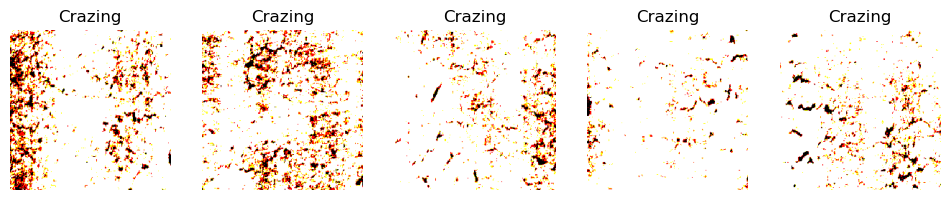

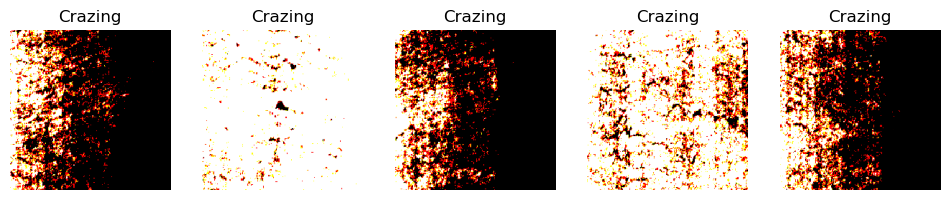

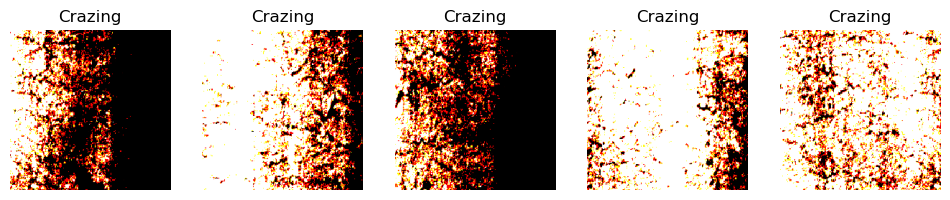

In [162]:
# Function to convert labels to class names
def get_class_name(label):
    class_names = sorted(os.listdir(train_data_dir))
    return class_names[label]

# Visualize some images from the dataset
def visualize_images(images, labels, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(get_class_name(np.argmax(labels[i])))  # Convert one-hot encoded labels back to integers
        plt.axis('off')
    plt.show()

# Visualize some images from the training data
visualize_images(train_images, train_labels)

# Visualize some images from the validation data
visualize_images(valid_images, valid_labels)

# Visualize some images from the testing data
visualize_images(test_images, test_labels)

In [163]:
# Define the number of training epochs
num_epochs = 10

In [164]:
# Train the model
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    history = model.fit(train_datagen.flow(train_images, train_labels, batch_size=batch_size),
                        steps_per_epoch=len(train_images) // batch_size, epochs=1,
                        validation_data=valid_datagen.flow(valid_images, valid_labels, batch_size=batch_size),
                        validation_steps=len(valid_images) // batch_size)
    
    train_loss_values.append(history.history['loss'][0])
    train_accuracy_values.append(history.history['accuracy'][0])
    val_loss_values.append(history.history['val_loss'][0])
    val_accuracy_values.append(history.history['val_accuracy'][0])


Epoch 1/10
51/51 [==============================] - 20s 362ms/step - loss: 1.1362 - accuracy: 0.6736 - val_loss: 0.1599 - val_accuracy: 0.9844
Epoch 2/10
51/51 [==============================] - 18s 347ms/step - loss: 0.4389 - accuracy: 0.8584 - val_loss: 0.1837 - val_accuracy: 0.9219
Epoch 3/10
51/51 [==============================] - 18s 362ms/step - loss: 0.3567 - accuracy: 0.8750 - val_loss: 0.0928 - val_accuracy: 0.9844
Epoch 4/10
51/51 [==============================] - 19s 369ms/step - loss: 0.3299 - accuracy: 0.8947 - val_loss: 0.0621 - val_accuracy: 0.9844
Epoch 5/10
51/51 [==============================] - 18s 360ms/step - loss: 0.2919 - accuracy: 0.8959 - val_loss: 0.0440 - val_accuracy: 1.0000
Epoch 6/10
51/51 [==============================] - 19s 371ms/step - loss: 0.2515 - accuracy: 0.9187 - val_loss: 0.0628 - val_accuracy: 0.9844
Epoch 7/10
51/51 [==============================] - 18s 360ms/step - loss: 0.2305 - accuracy: 0.9249 - val_loss: 0.0381 - val_accuracy: 0.9844

In [165]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images, test_labels, batch_size=batch_size),
                                          steps=len(test_images) // batch_size)

print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

# Make predictions on the test data
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded test_labels back to integers
test_labels_int = np.argmax(test_labels, axis=1)

# Calculate precision, recall, F1 score, and accuracy
report = classification_report(test_labels_int, y_pred_classes, zero_division=1)
accuracy = accuracy_score(test_labels_int, y_pred_classes)

print("Classification Report:")
print(report)

print("Test Accuracy:", accuracy)

2/2 [==============================] - 0s 74ms/step - loss: 0.0903 - accuracy: 0.9688
Test loss: 0.09026608616113663, Test accuracy: 0.96875
3/3 [==============================] - 0s 61ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        12
           1       1.00      0.00      0.00        12
           2       0.29      1.00      0.45        12
           3       0.67      0.33      0.44        12
           4       1.00      0.00      0.00        12
           5       0.44      0.92      0.59        12

    accuracy                           0.38        72
   macro avg       0.73      0.38      0.25        72
weighted avg       0.73      0.38      0.25        72

Test Accuracy: 0.375


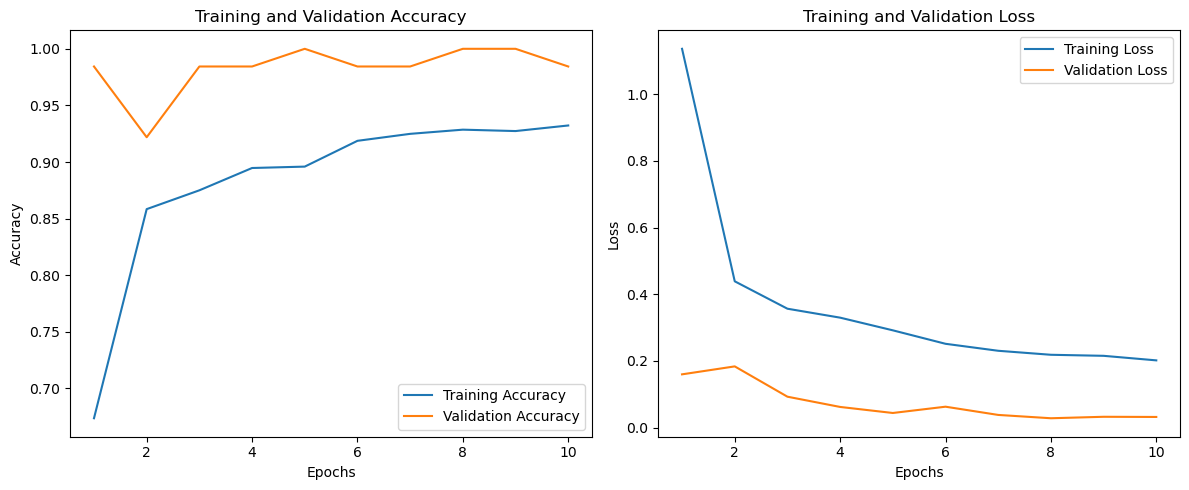

In [166]:
# Plot accuracy and loss curves
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy_values, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_values, label='Training Loss')
plt.plot(epochs_range, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()